# Programming Assignment: Размещение баннеров

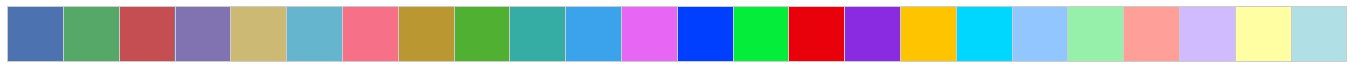

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
from contextlib import contextmanager

sns.set()
sns.set_style("whitegrid")

color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline
sns.palplot(color_palette)

def ndprint(a, precision=3):
    with np.printoptions(precision=precision, suppress=True):
        print(a)

## Problem

Представим, что международное круизное агентство Carnival Cruise Line решило себя разрекламировать с помощью баннеров и обратилось для этого к вам. Чтобы протестировать, велика ли от таких баннеров польза, их будет размещено всего 20 штук по всему миру. Вам надо выбрать 20 таких локаций для размещения, чтобы польза была большой и агентство продолжило с вами сотрудничать.

Агентство крупное, и у него есть несколько офисов по всему миру. Вблизи этих офисов оно и хочет разместить баннеры — легче договариваться и проверять результат. Также эти места должны быть популярны среди туристов.

## Get data

Для поиска оптимальных мест воспользуемся базой данных крупнейшей социальной сети, основанной на локациях — Foursquare.

Часть открытых данных есть, например, на сайте archive.org:

https://archive.org/details/201309_foursquare_dataset_umn

Скачаем любым удобным образом архив fsq.zip с этой страницы.

In [2]:
import os.path
import requests
from zipfile import ZipFile

def fetch_file(url, filename):
    if os.path.exists(filename):
        return
    response = requests.get(url, stream=True)
    with open(filename, "wb") as handle:
        for data in response.iter_content():
            handle.write(data)            

def extract_zip(from_path, to_path):
    with ZipFile(from_path, 'r') as zip_ref:
        zip_ref.extractall(to_path)
        
def fetch_data():
    if os.path.exists('data/02_checkins.csv'):
        return
    
    # download zip dataset to temp
    tmp_path = os.path.expanduser('~/AppData/Local/Temp/')
    dataset_zip = os.path.join(tmp_path, 'foursquare_dataset.zip')
    fetch_file('https://archive.org/download/201309_foursquare_dataset_umn/fsq.zip', dataset_zip)
    
    # extract zip
    extracted_data_path = os.path.join(tmp_path, 'foursquare_dataset')
    extract_zip(dataset_zip, extracted_data_path)
    
    # read, clean, save to `data` folder
    extracted_data_path = os.path.join(tmp_path, 'foursquare_dataset/umn_foursquare_datasets/checkins.dat')
    data = pd.read_csv(extracted_data_path, sep='|', low_memory=False, skiprows=[1], skipinitialspace=True, usecols=[3, 4])
    data.dropna(inplace=True)
    data.columns = [col.strip() for col in data.columns]

    data.to_csv('data/02_checkins.csv')

Нас будет интересовать файл checkins.dat. Открыв его, увидим следующую структуру:

In [3]:
fetch_data()

In [17]:
data = pd.read_csv('data/02_checkins.csv')

In [18]:
data.head()

,ind,latitude,longitude
0,1,38.895112,-77.036366
1,3,33.800745,-84.410520
2,7,45.523452,-122.676207
3,9,40.764462,-111.904565
4,10,33.448377,-112.074037


## Выборка

In [5]:
from sklearn import datasets, metrics, model_selection as mdsel, tree, ensemble, neighbors

train_all = datasets.fetch_20newsgroups(subset='train')
print(train_all.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [7]:
simple_dataset = datasets.fetch_20newsgroups(
    subset='train', 
    categories=['comp.sys.mac.hardware', 'soc.religion.christian', 'rec.sport.hockey']
)

In [8]:
print(simple_dataset.data[0])

From: erik@cheshire.oxy.edu (Erik Adams)
Subject: HELP!!  My Macintosh "luggable" has lines on its screen!
Organization: Occidental College, Los Angeles, CA 90041 USA.
Distribution: comp
Lines: 20

Okay, I don't use it very much, but I would like for it to keep working
correctly, at least as long as Apple continues to make System software
that will run on it, if slowly :-)

Here is the problem:  When the screen is tilted too far back, vertical
lines appear on the screen.  They are every 10 pixels or so, and seem
to be affected somewhat by opening windows and pulling down menus.
It looks to a semi-technical person like there is a loose connection
between the screen and the rest of the computer.

I am open to suggestions that do not involve buying a new computer,
or taking this one to the shop.  I would also like to not have
to buy one of Larry Pina's books.  I like Larry, but I'm not sure
I feel strongly enough about the computer to buy a service manual
for it.

On a related note:  what

In [9]:
simple_dataset.target

array([0, 0, 1, ..., 0, 1, 2], dtype=int64)

In [11]:
print(simple_dataset.data[-1])

From: dlecoint@garnet.acns.fsu.edu (Darius_Lecointe)
Subject: Re: Sabbath Admissions 5of5
Organization: Florida State University
Lines: 21

I find it interesting that cls never answered any of the questions posed. 
Then he goes on the make statements which make me shudder.  He has
established a two-tiered God.  One set of rules for the Jews (his people)
and another set for the saved Gentiles (his people).  Why would God
discriminate?  Does the Jew who accepts Jesus now have to live under the
Gentile rules.

God has one set of rules for all his people.  Paul was never against the
law.  In fact he says repeatedly that faith establishes rather that annuls
the law.  Paul's point is germane to both Jews and Greeks.  The Law can
never be used as an instrument of salvation.  And please do not combine
the ceremonial and moral laws in one.

In Matt 5:14-19 Christ plainly says what He came to do and you say He was
only saying that for the Jews's benefit.  Your Christ must be a
politician, speaki

In [12]:
print(simple_dataset.data[-2])

From: scialdone@nssdca.gsfc.nasa.gov (John Scialdone)
Subject: CUT Vukota and Pilon!!!
News-Software: VAX/VMS VNEWS 1.41    
Organization: NASA - Goddard Space Flight Center
Lines: 32

I have been to all 3 Isles/Caps tilts at the Crap Centre this year, all Isles
wins and there is no justification for Vukota and Pilon to play for the Isles.
Vukota is absolutely the worst puck handler in the world!! He couldn't hit a
bull in the ass with a banjo!! Al must remember a few years back when Mick 
scored 3 goals in one period against the Caps in a 5-3 Isles win. I was there
and was astonished as was the rest of the crowd. Wake-up Al!!! Years later he's
gotten worse. He's a cheap shot artist and always ends up getting
stupid/senseless penalties. I think he would make a good police officier!!!

As for Pilon, he can't carry the puck out to center ice by himself. He either
makes a bad pass resulting in a turnover, or he attempts to bring the puck 
towards the neutral zone and skates right into an 

In [13]:
len(simple_dataset.data)

1777

## Признаки

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=500, min_df=10)
matrix = vectorizer.fit_transform(simple_dataset.data)

In [15]:
matrix.shape

(1777, 3767)

## Аггломеративная кластеризация (neighbour joining)

In [26]:
from sklearn.cluster.hierarchical import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=3, affinity='cosine', linkage='complete')
preds = model.fit_predict(matrix.toarray())

In [27]:
list(preds)[:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [20]:
print(matrix[0])

  (0, 1246)	0.3906389385132699
  (0, 239)	0.09501028877632492
  (0, 1659)	0.07226670936760915
  (0, 2082)	0.09656717763921
  (0, 1846)	0.06741426312477893
  (0, 2991)	0.3895610830528872
  (0, 810)	0.0809427637021726
  (0, 2056)	0.09616720743610424
  (0, 319)	0.10054935380579341
  (0, 625)	0.05207173909126517
  (0, 3553)	0.07346689959490565
  (0, 1121)	0.06442816229222373
  (0, 838)	0.10154477899829951
  (0, 69)	0.06858267052730141
  (0, 2413)	0.10258878033617379
  (0, 3555)	0.06229087987706688
  (0, 3600)	0.05737015279917228
  (0, 2273)	0.057960021837659234
  (0, 1905)	0.08173536478989506
  (0, 3722)	0.09501028877632492
  (0, 926)	0.11742059318548873
  (0, 1991)	0.0711302768586001
  (0, 2048)	0.07488448956033757
  (0, 354)	0.06947437383545055
  (0, 900)	0.12357635170024021
  :	:
  (0, 2868)	0.08596208970791505
  (0, 855)	0.20162554088271673
  (0, 301)	0.055632566960467825
  (0, 2422)	0.09427236106959615
  (0, 3285)	0.11264581593118286
  (0, 1831)	0.1250526461821779
  (0, 620)	0.1118065

In [28]:
vectorizer.get_feature_names()[:10]

['00', '000', '01', '02', '03', '030', '0358', '04', '040', '05']

In [29]:
vectorizer.get_feature_names()[877]

'connect'

In [30]:
simple_dataset.data[0]

'From: erik@cheshire.oxy.edu (Erik Adams)\nSubject: HELP!!  My Macintosh "luggable" has lines on its screen!\nOrganization: Occidental College, Los Angeles, CA 90041 USA.\nDistribution: comp\nLines: 20\n\nOkay, I don\'t use it very much, but I would like for it to keep working\ncorrectly, at least as long as Apple continues to make System software\nthat will run on it, if slowly :-)\n\nHere is the problem:  When the screen is tilted too far back, vertical\nlines appear on the screen.  They are every 10 pixels or so, and seem\nto be affected somewhat by opening windows and pulling down menus.\nIt looks to a semi-technical person like there is a loose connection\nbetween the screen and the rest of the computer.\n\nI am open to suggestions that do not involve buying a new computer,\nor taking this one to the shop.  I would also like to not have\nto buy one of Larry Pina\'s books.  I like Larry, but I\'m not sure\nI feel strongly enough about the computer to buy a service manual\nfor it.\n

## KMeans

In [31]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3, random_state=1)
preds = model.fit_predict(matrix.toarray())
print(preds)

[0 0 2 ... 0 2 1]


In [32]:
print(simple_dataset.target)

[0 0 1 ... 0 1 2]


In [33]:
mapping = {2 : 1, 1: 2, 0: 0}
mapped_preds = [mapping[pred] for pred in preds]
print(float(sum(mapped_preds != simple_dataset.target)) / len(simple_dataset.target))

0.04727068092290377


In [36]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='lbfgs', multi_class='auto')
print(mdsel.cross_val_score(clf, matrix, simple_dataset.target, cv=3).mean())


0.9864864479274559


## Более сложная выборка

In [49]:
dataset = datasets.fetch_20newsgroups(
    subset='train', 
    categories=['comp.sys.mac.hardware', 'comp.os.ms-windows.misc', 'comp.graphics'])

In [50]:
matrix = vectorizer.fit_transform(dataset.data)
model = KMeans(n_clusters=3, random_state=42)
preds = model.fit_predict(matrix.toarray())
print(preds)
print(dataset.target)

[2 1 0 ... 2 0 2]
[2 1 1 ... 2 0 2]


In [51]:
mapping = {2 : 2, 1: 1, 0: 0}
mapped_preds = [mapping[pred] for pred in preds]
print(float(sum(mapped_preds != dataset.target)) / len(dataset.target))

0.23217341699942956


In [52]:
clf = LogisticRegression(solver='lbfgs', multi_class='auto')
print(mdsel.cross_val_score(clf, matrix, dataset.target, cv=3).mean())

0.9178509820019255


## SVD + KMeans

In [53]:
from sklearn.decomposition import TruncatedSVD

model = KMeans(n_clusters=3, random_state=42)
svd = TruncatedSVD(n_components=1000, random_state=123)
features = svd.fit_transform(matrix)
preds = model.fit_predict(features)
print(preds)
print(dataset.target)

[0 2 1 ... 0 1 0]
[2 1 1 ... 2 0 2]


In [54]:
mapping = {0 : 2, 1: 0, 2: 1}
mapped_preds = [mapping[pred] for pred in preds]
print(float(sum(mapped_preds != dataset.target)) / len(dataset.target))

0.2065031374786081


In [46]:
model = KMeans(n_clusters=3, random_state=42)
svd = TruncatedSVD(n_components=200, random_state=123)
features = svd.fit_transform(matrix)
preds = model.fit_predict(features)
print(preds)
print(dataset.target)

[2 0 1 ... 2 1 2]
[2 1 1 ... 2 0 2]


In [47]:
import itertools
def validate_with_mappings(preds, target, dataset):
    permutations = itertools.permutations([0, 1, 2])
    for a, b, c in permutations:
        mapping = {2 : a, 1: b, 0: c}
        mapped_preds = [mapping[pred] for pred in preds]
        print(float(sum(mapped_preds != target)) / len(target))
        
validate_with_mappings(preds, dataset.target, dataset)

0.9007415858528237
0.6742726754135767
0.7056474614945807
0.8938961779806047
0.2053622361665716
0.6200798630918426


In [48]:
model = KMeans(n_clusters=3, random_state=42)
svd = TruncatedSVD(n_components=200, random_state=321)
features = svd.fit_transform(matrix)
preds = model.fit_predict(features)
print(preds)
print(dataset.target)
validate_with_mappings(preds, dataset.target, dataset)

[2 1 0 ... 2 0 2]
[2 1 1 ... 2 0 2]
0.713063320022818
0.845407872219053
0.8893325727324587
0.7005134055904164
0.5864232743867656
0.2652595550484883


## Итоги

1. Получили интерпретируемый результат на обеих выборках
1. Реальность, однако, намного более жестока
1. Попробовали использовать AgglomerativeClustering и KMeans